In [15]:
import cobra
from cobra.io import read_sbml_model
from pprint import pprint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from process_bigraph import Composite
from process_bigraph import ProcessTypes
from process_bigraph.emitter import gather_emitter_results

from cdFBA import register_types
from cdFBA.processes.dfba import dFBA, UpdateEnvironment, StaticConcentration, Injector, WaveFunction

from cdFBA.utils import make_cdfba_composite, get_injector_spec, get_wave_spec, get_static_spec, set_concentration, set_kinetics

In [ ]:
# Goal: Replicate Adrian et al. model quantitatively using cdFBA

# 3 bacteria species
# /Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml/Bacteroides_thetaiotaomicron_VPI_5482.xml
# /Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml/Methanobrevibacter_smithii_ATCC_35061.xml
# /Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml/Eubacterium_rectale_ATCC_33656.xml

In [ ]:
b_thetaiotaomicron = cobra.io.read_sbml_model("/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml/Bacteroides_thetaiotaomicron_VPI_5482.xml")
b_thetaiotaomicron.optimize()
b_thetaiotaomicron.summary()

In [ ]:
e_rectale = cobra.io.read_sbml_model("/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml/Eubacterium_rectale_ATCC_33656.xml")
e_rectale.optimize()
e_rectale.summary()

In [ ]:
m_simithii = cobra.io.read_sbml_model("/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml/Methanobrevibacter_smithii_ATCC_35061.xml")
m_simithii.optimize()
m_simithii.summary()

In [ ]:
# interested in following exchange reactions: acetate, butyrate, CO2, H2, CH4, and a polysaccharide

In [6]:
gut_models = {
        "B_thetaiotaomicron": "Bacteroides_thetaiotaomicron_VPI_5482.xml",
        "E_rectale": "Eubacterium_rectale_ATCC_33656.xml",
        "Methanobrevibacter_smithii": "Methanobrevibacter_smithii_ATCC_35061.xml"
    }

exchanges = ['EX_ac(e)', 'EX_bu(e)t', 'EX_co2', 'EX_h(e)', 'EX_ch4(e)', 'EX_cholate(e)'] # acetate, butyrate, CO2, H2, methane, exopolysaccharide

volume = 2

# dFBA model
spec = make_cdfba_composite(gut_models, medium_type=None, exchanges=exchanges, volume=volume, interval=0.1)

pprint(spec) # Problem: Why is it writing my model into the shared environment?

{'Shared Environment': {'concentrations': {'B_thetaiotaomicron': 0.25,
                                           'Cholate': 10.0,
                                           'E_rectale': 0.25,
                                           'Methane': 10.0,
                                           'Methanobrevibacter_smithii': 0.25,
                                           'acetate': 10.0,
                                           'proton': 10.0},
                        'counts': {'B_thetaiotaomicron': 0.5,
                                   'Cholate': 20,
                                   'E_rectale': 0.5,
                                   'Methane': 20,
                                   'Methanobrevibacter_smithii': 0.5,
                                   'acetate': 20,
                                   'proton': 20},
                        'volume': 2},
 'Species': {'B_thetaiotaomicron': {'_type': 'process',
                                    'address': 'local:dFBA',
        

In [ ]:
#Set reaction bounds
spec['Species']['B_thetaiotaomicron']['config']['bounds'] = {
            "EX_o2_e": {"lower": -2, "upper": None},
            "ATPM": {"lower": 1, "upper": 1},
            'EX_glc__D_e': {"lower":0, "higher": 0}
        }
spec['Species']['E_rectale']['config']['bounds'] = {
            "EX_o2_e": {"lower": -2, "upper": None},
            "ATPM": {"lower": 1, "upper": 1},
            'EX_glc__D_e': {"lower":0, "higher": 0}
        }
spec['Species']['Methanobrevibacter_smithii']['config']['bounds'] = {
            "EX_o2_e": {"lower": -2, "upper": None},
            "ATPM": {"lower": 1, "upper": 1},
            'EX_glc__D_e': {"lower":0, "higher": 0}
        }

In [7]:
#set external substrate concentrations
concentrations = {      # abundance of polysaccharide, limit acetate so that it has to come from keystone species
    'acetate': 0,
    'Cholate': 5
}
set_concentration(spec, concentrations)

In [10]:
#set kinetics
kinetics = {
    'acetate': (0.5, 5),
    'Cholate': (0.5, 5)
}
for species in gut_models.keys():
    set_kinetics(species, spec, kinetics)
pprint(spec)

{'Shared Environment': {'concentrations': {'B_thetaiotaomicron': 0.25,
                                           'Cholate': 5,
                                           'E_rectale': 0.25,
                                           'Methane': 10.0,
                                           'Methanobrevibacter_smithii': 0.25,
                                           'acetate': 0,
                                           'proton': 10.0},
                        'counts': {'B_thetaiotaomicron': 0.5,
                                   'Cholate': 10,
                                   'E_rectale': 0.5,
                                   'Methane': 20,
                                   'Methanobrevibacter_smithii': 0.5,
                                   'acetate': 0,
                                   'proton': 20},
                        'volume': 2},
 'Species': {'B_thetaiotaomicron': {'_type': 'process',
                                    'address': 'local:dFBA',
               

In [11]:
#set emitter specs
spec['emitter'] = {
        "_type": "step",
        "address": "local:ram-emitter",
        "config": {
            "emit": {
                "shared_environment": "any",
                "global_time": "any",
            }
        },
        "inputs": {
            "shared_environment": ["Shared Environment"],
            "global_time": ["global_time"]
        }
    }

In [16]:
#create the core object
core = ProcessTypes()
#register data types
core = register_types(core)
#register all processes and steps
core.register_process('dFBA', dFBA)
core.register_process('UpdateEnvironment', UpdateEnvironment)
core.register_process('StaticConcentration', StaticConcentration)
core.register_process('WaveFunction', WaveFunction)
core.register_process('Injector', Injector)

In [17]:
#create simulation composite
sim = Composite({
        "state": spec,
        },
        core=core
    )

In [18]:
#run simulation
sim.run(20)

In [19]:
#gather results
results = gather_emitter_results(sim)[('emitter',)]

In [20]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
env = [timepoint['shared_environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

In [21]:
results # Problem: Why am I getting such high numbers in my counts?

[{'shared_environment': {'concentrations': {'acetate': 0.0,
    'Cholate': 5.0,
    'proton': 10.0,
    'Methane': 10.0,
    'B_thetaiotaomicron': 0.25,
    'E_rectale': 0.25,
    'Methanobrevibacter_smithii': 0.25},
   'counts': {'acetate': 0.0,
    'Cholate': 10.0,
    'proton': 20.0,
    'Methane': 20.0,
    'B_thetaiotaomicron': 0.5,
    'E_rectale': 0.5,
    'Methanobrevibacter_smithii': 0.5},
   'volume': 2.0}},
 {'shared_environment': {'counts': {'acetate': 0.0,
    'Cholate': 10.0,
    'proton': 20.0,
    'Methane': 20.0,
    'B_thetaiotaomicron': 0.5,
    'E_rectale': 0.5,
    'Methanobrevibacter_smithii': 0.5},
   'concentrations': {'acetate': 0.0,
    'Cholate': 5.0,
    'proton': 10.0,
    'Methane': 10.0,
    'B_thetaiotaomicron': 0.25,
    'E_rectale': 0.25,
    'Methanobrevibacter_smithii': 0.25},
   'volume': 2.0}},
 {'shared_environment': {'counts': {'acetate': np.float64(51.69070961121388),
    'Cholate': np.float64(32.08290286267131),
    'proton': np.float64(116.341

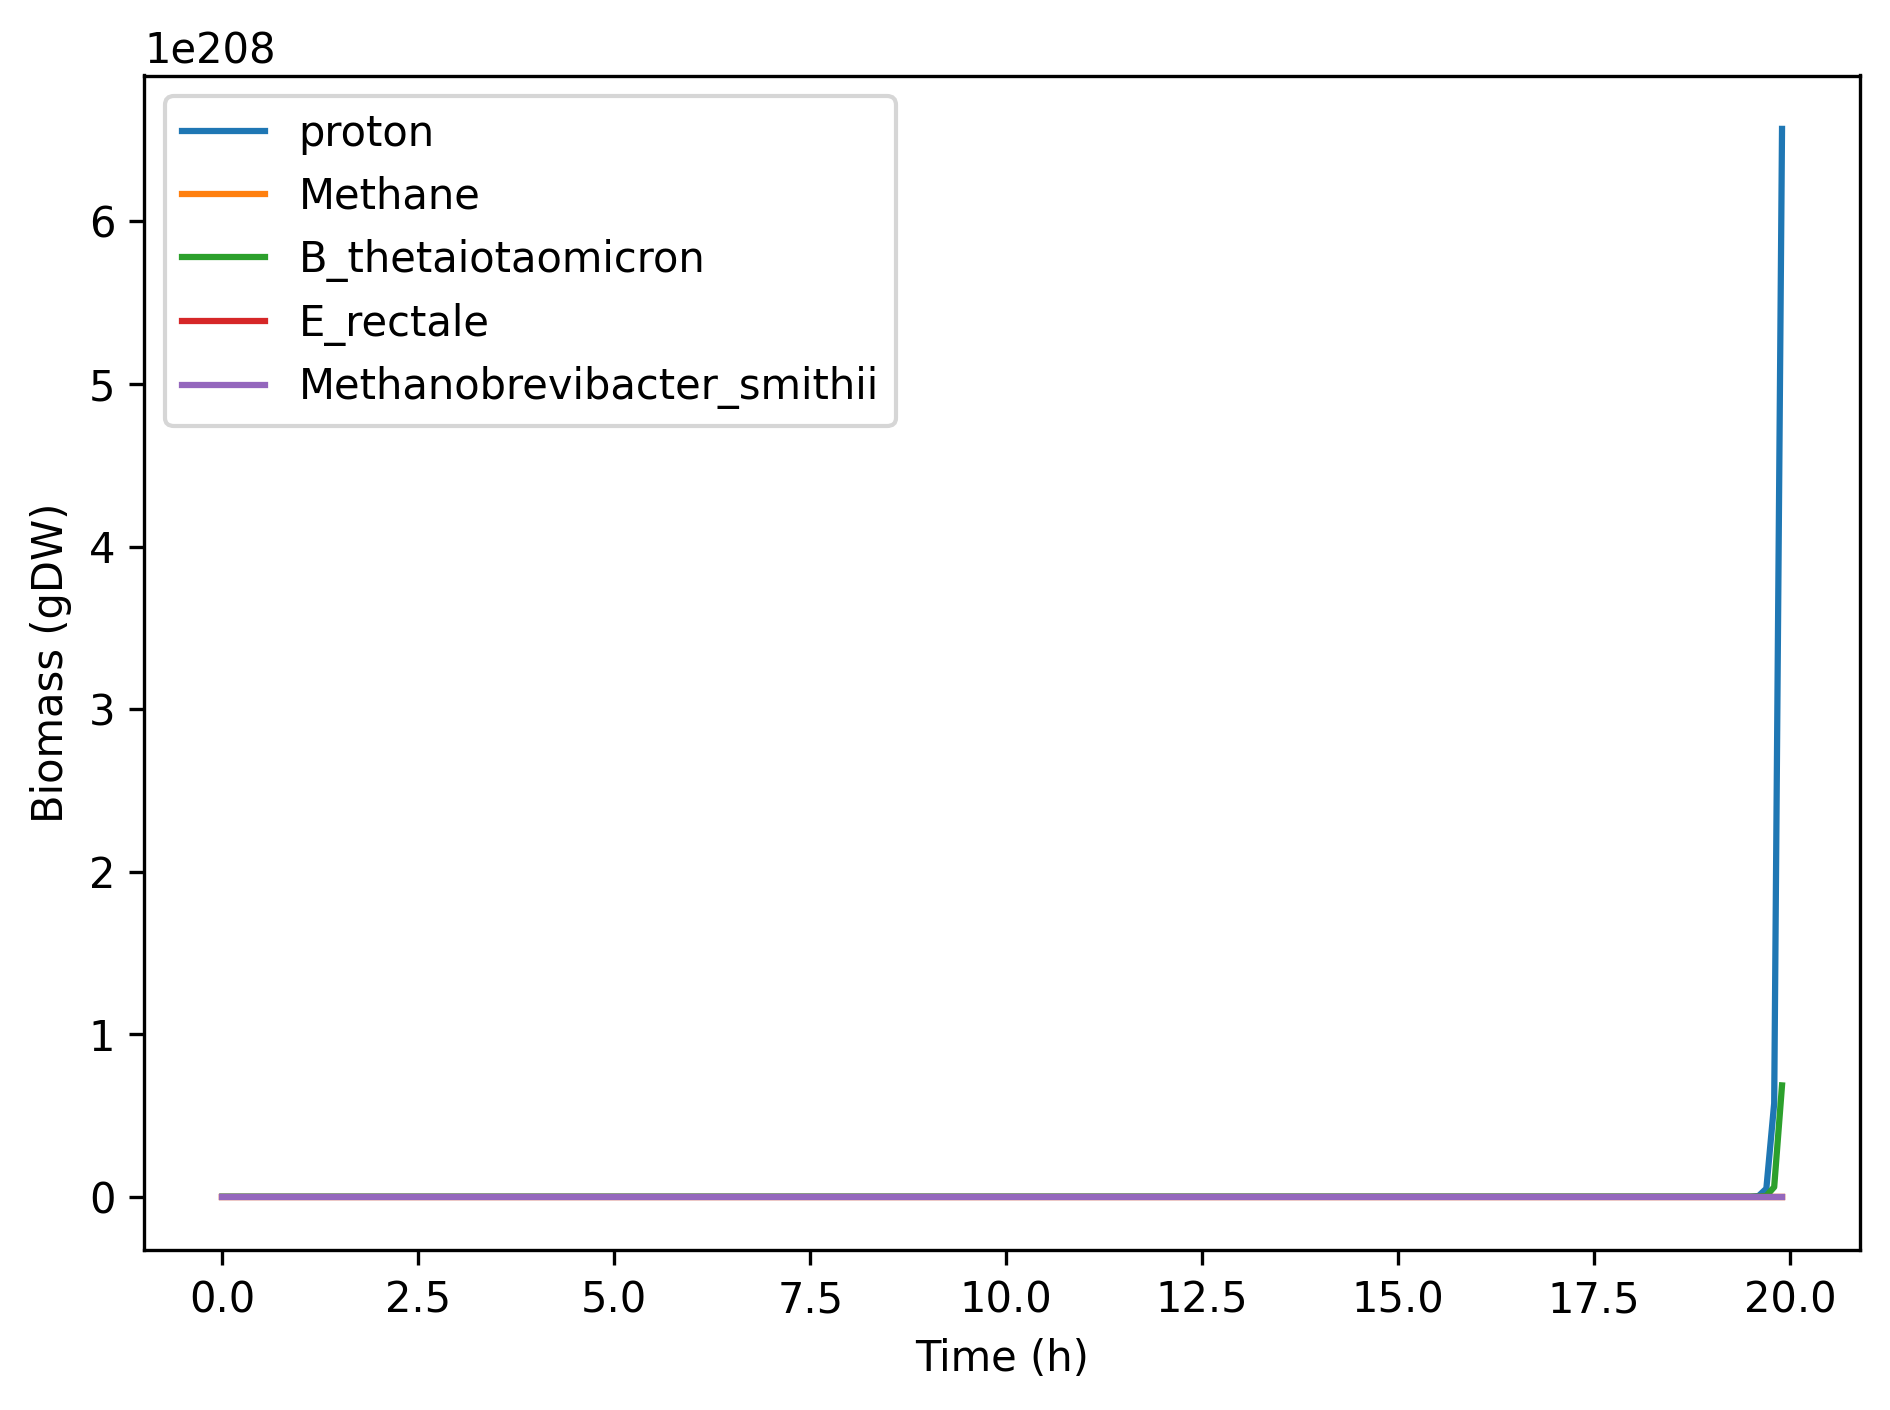

In [25]:
#plot results for biomass
fig, ax = plt.subplots(dpi=300)
for key, value in env_combined.items():
    if key not in ['acetate', 'Cholate']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time (h)')
plt.ylabel('Biomass (gDW)')
plt.legend()
plt.tight_layout()
plt.show()

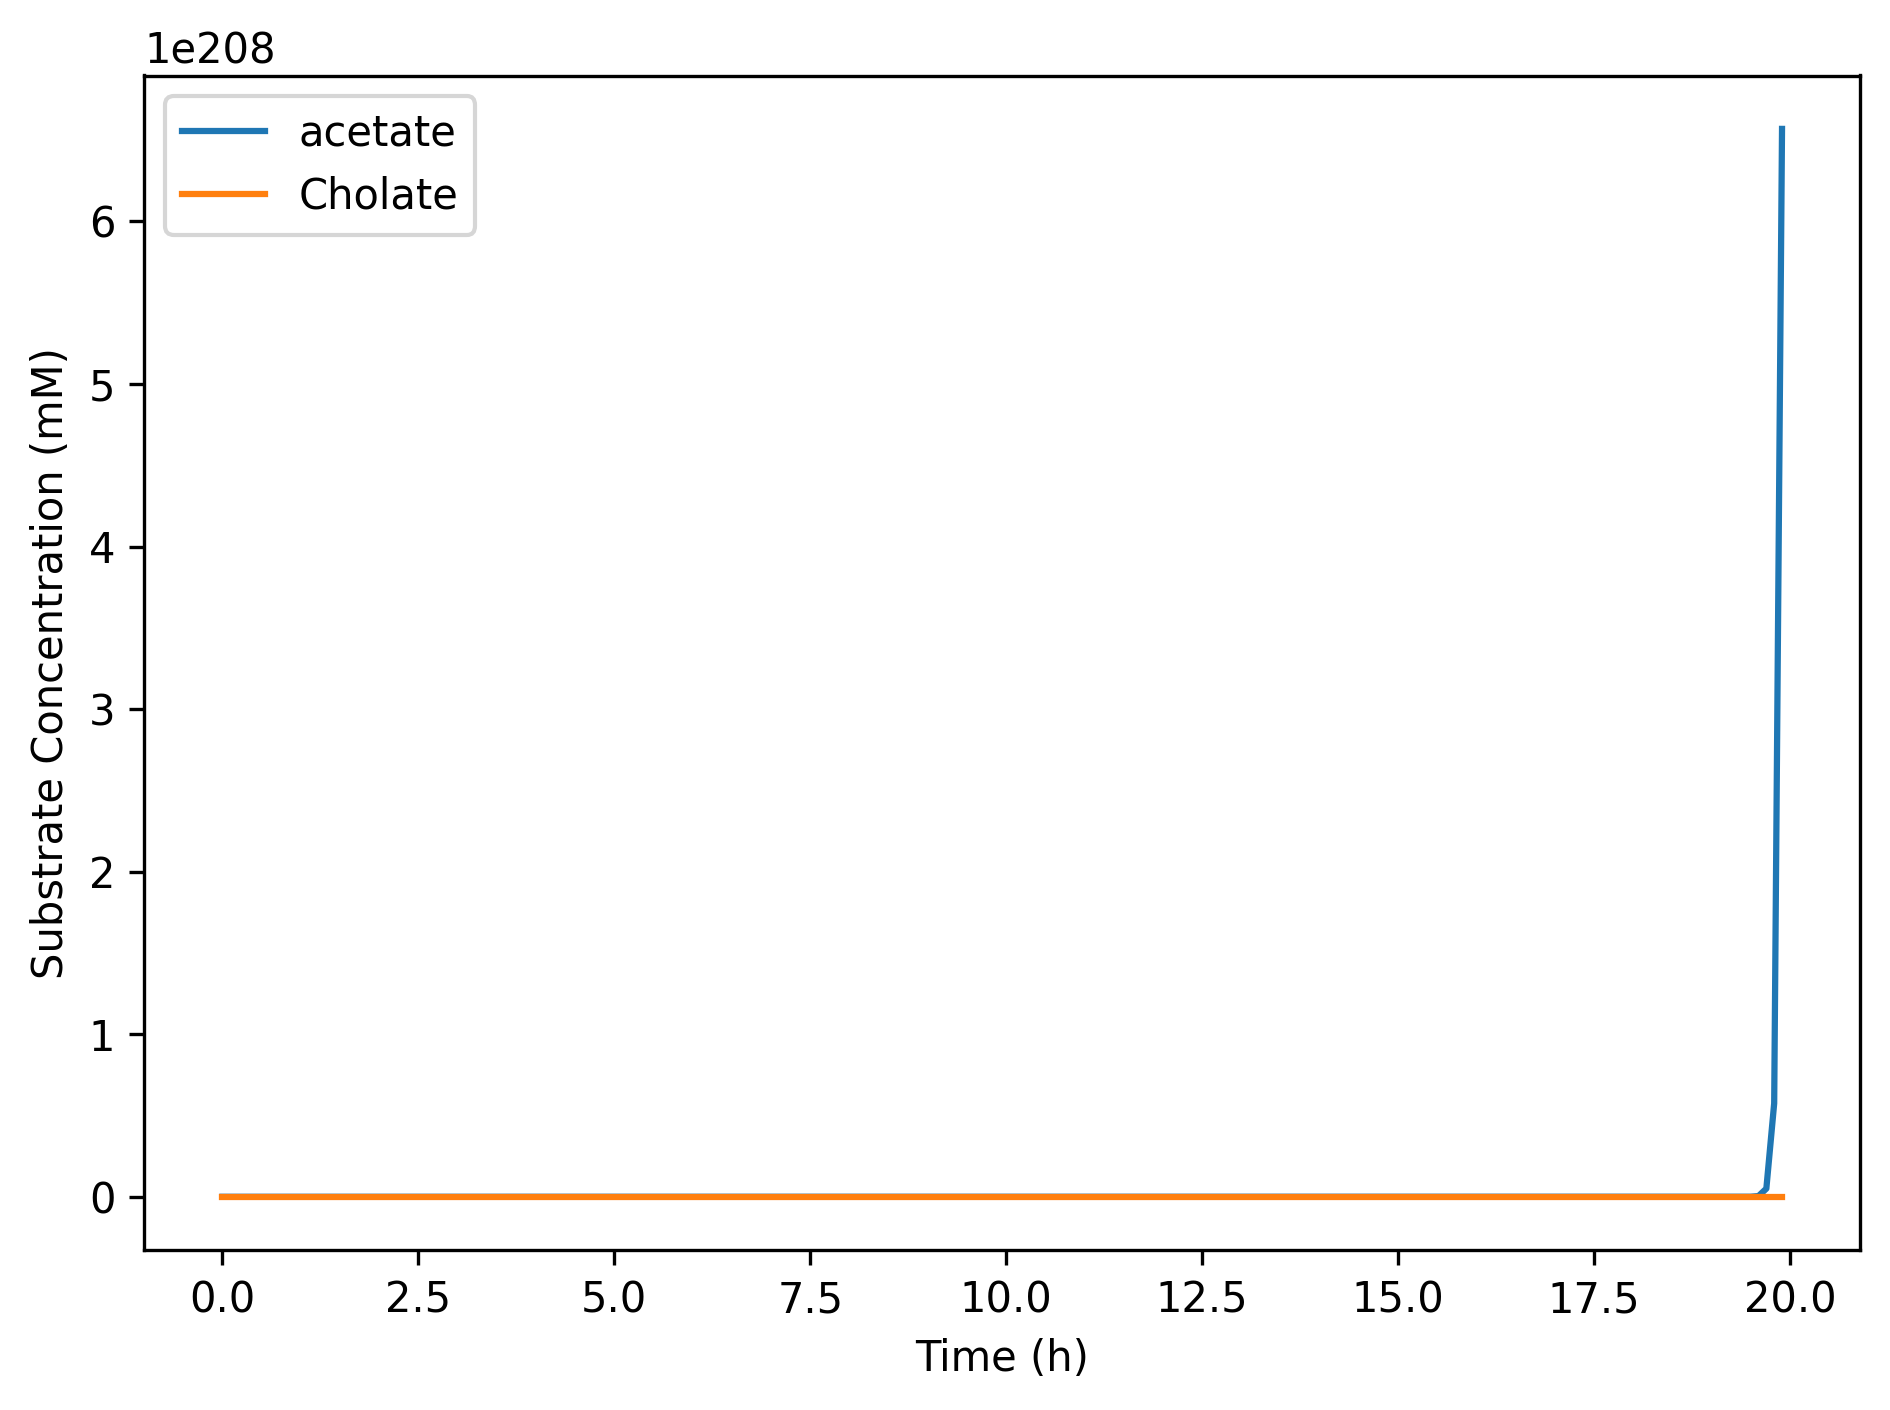

In [27]:
#plot substrates
fig, ax = plt.subplots(dpi=300)
for key, value in env_combined.items():
    if key in ['acetate', 'Cholate']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time (h)')
plt.ylabel('Substrate Concentration (mM)')
plt.legend()
plt.tight_layout()
plt.show()